In [49]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as F

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.ranking import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [50]:
image_set_csv = 'CheXpert-v1.0-small/train.csv'
image_set = 'CheXpert-v1.0-small/train'

test_set_csv = 'CheXpert-v1.0-small/valid.csv'
test_set = 'CheXpert-v1.0-small/valid'

use_gpu = torch.cuda.is_available()

pretrained = True                
classes = 14  
batch_size = 16
epochs = 5
resize_im = 224
#'Enlarged Cardiomediastinum', 'Pneumonia', 'Atelectasis', 

# class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
#                'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
#                'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

class_names = ['Lung Lesion']
pathology = 'Lung Lesion'


In [51]:
class Siamese_CheXpertDataSet(Dataset):
    def __init__(self, image_set_csv, image_set,set_type, pathology, transform=None):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        """
        df_train = pd.read_csv(image_set_csv)
        df_train = df_train.fillna(0)
        df_train = df_train.replace([-1], 1)
        if set_type == 'train' or set_type == 'val':
            X_train, X_val, y_train, y_val = train_test_split(df_train.loc[:,df_train.columns!=pathology], df_train[pathology], test_size=0.15, random_state=42, stratify = df_train[pathology])
            X_train = X_train.join(y_train)
            X_val = X_val.join(y_val)
        # only keep if data still missing 
#         if set_type == 'train':
#           listim = os.listdir(image_set) #change back
#           newim = [x for x in df_train["Path"] if x[x.rfind('train')+6:x.rfind('study')-1] in listim]
#           df_train = df_train[df_train['Path'].isin(newim)]
#         if set_type == 'valid':
#           listim = os.listdir(image_set) #change back
#           newim = [x for x in df_train["Path"] if x[x.rfind('valid')+6:x.rfind('study')-1] in listim]
#           df_train = df_train[df_train['Path'].isin(newim)]
        #till here
        if set_type == 'train':
            self.df = X_train[['Path',pathology]]
            self.images_names = list(X_train["Path"])
        elif set_type == 'val':
            self.df = X_val[['Path',pathology]]
            self.images_names = list(X_val["Path"])
        else: 
            self.df = df_train[['Path',pathology]]
            self.images_names = list(df_train["Path"])

        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        #Assuming -1 are equivalent to 0
        df_ones = self.df[self.df[pathology]==1]
        df_others = self.df[self.df[pathology]!=1]
        index = np.random.randint(0,len(self.images_names))
        same_class = np.random.randint(0,2) 
        anchor_class = np.random.randint(0,2) 
        #image_names = df_train[:,[pathology]] == 1
        # .5 for uncertainty?
        if same_class:
            if anchor_class:
                image = np.random.choice(df_ones['Path'],2)
                image_1 = image[0]
                image_2 = image[1]
            else:
                image = np.random.choice(df_others['Path'],2)
                image_1 = image[0]
                image_2 = image[1]
            label = 1
        else:
            image_1 = np.random.choice(df_ones['Path'])
            image_2 = np.random.choice(df_others['Path'])
            label = 0

#         if same_class: 
#           while True:
#             images = np.random.choice(self.images_names,2, replace = False)
#             print(images[0])
#             if int(self.df.loc[self.df["Path"]==images[0],pathology]) == int(self.df.loc[self.df["Path"]==images[1],pathology]):
#               label = 0
#               break
#         else:
#           while True:
#             images = np.random.choice(self.images_names,2, replace = False)
#             if int(self.df.loc[self.df["Path"]==images[0],pathology]) != int(self.df.loc[self.df["Path"]==images[1],pathology]):
#               label = 1
#               break

#         image_1 = Image.open(images[0]).convert('RGB')
#         image_2 = Image.open(images[1]).convert('RGB')

        image_1 = Image.open(image_1).convert('RGB')
        image_2 = Image.open(image_2).convert('RGB')
        if self.transform is not None:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)
        return image_1, image_2, label

    def __len__(self):
        return len(self.images_names)

In [52]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList= []
transformList.append(transforms.RandomVerticalFlip())
transformList.append(transforms.Resize((resize_im, resize_im)))
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence_train=transforms.Compose(transformList)

transformList= []
transformList.append(transforms.Resize((resize_im, resize_im)))
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence_val=transforms.Compose(transformList)

In [53]:
pathology = 'Lung Lesion'
datasetTrain = Siamese_CheXpertDataSet(image_set_csv,image_set,'train',pathology,transformSequence_train)
datasetVal = Siamese_CheXpertDataSet(image_set_csv,image_set,'val',pathology,transformSequence_val)

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=batch_size, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [54]:
# def imshow(img,text=None,should_save=False):
#     npimg = img.numpy()
#     plt.axis("off")
#     if text:
#         plt.text(75, 8, text, style='italic',fontweight='bold',
#             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()  
# dataiter = iter(dataLoaderTrain)

# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [55]:
class ContrastiveLoss(torch.nn.Module):

      def __init__(self, margin):
            super(ContrastiveLoss, self).__init__()
            self.margin = margin
            self.eps = 1e-9

      def forward(self, output1, output2, label):
#             print(output1.shape)
#             print(output2.shape)
#             print(label.shape)
#             print(label)
            # Find the pairwise distance or eucledian distance of two output feature vectors
            euclidean_distance = F.pairwise_distance(output1, output2)
            # perform contrastive loss calculation with the distance
            loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - (euclidean_distance+self.eps), min=0.0), 2))

            return loss_contrastive
        
loss = ContrastiveLoss(margin=10)

In [56]:
class Siamese_DenseNet121(nn.Module):
    def __init__(self, classNum, pretrained):

        super(Siamese_DenseNet121, self).__init__()

        self.densenet121 = torchvision.models.densenet121(pretrained=pretrained, memory_efficient=True)
        prevNum = self.densenet121.classifier.in_features
        #replacing classifier FC for 1 class
        self.densenet121.classifier = nn.Sequential(nn.Linear(prevNum, classNum), nn.ReLU())

    def forward_once(self, x):
        x = self.densenet121(x)
        return x

    def forward(self, input1, input2):
        output1 = self.densenet121(input1)
        output2 = self.densenet121(input2)
        return output1, output2

In [89]:
class Siamese_ChexpertTrainer():
 
    def train (dataloaderTrain, dataloaderVal, pretrained, classes, batch_size, epoch, resize_im, launchTimestamp, checkpoint):

        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE
        #model = DenseNet121(classes, pretrained).cuda()
        model = Siamese_DenseNet121(classes, pretrained).cuda()
        # model = torch.nn.DataParallel(model).cuda()

        #-------------------- SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')
        
        #---- Load checkpoint 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        
        #---- TRAIN THE NETWORK
        
        lossMIN = np.inf
        
        for epochID in range (0, epoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
                         
            Siamese_ChexpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, scheduler, epoch, classes, loss)
            lossVal, losstensor = Siamese_ChexpertTrainer.epochVal (model, dataLoaderVal, optimizer, scheduler, epoch, classes, loss)
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            scheduler.step(losstensor)
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'siamese_models/'+'m-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
                     
    #-------------------------------------------------------------------------------- 
       
    def epochTrain (model, dataLoader, optimizer, scheduler, epochMax, classCount, loss):
        
        model.train()
        
        for batchID, (input_1, input_2, target) in enumerate (dataLoader):
                        
            input_1 = input_1.cuda()
            input_2 = input_2.cuda()
            target = target.cuda(non_blocking = True)
                         
            varOutput_1,varOutput_2 = model(input_1,input_1)
            
            lossvalue = loss(varOutput_1,varOutput_2,target)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
    #-------------------------------------------------------------------------------- 
        
    def epochVal (model, dataLoader, optimizer, scheduler, epochMax, classCount, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0
        
        losstensorMean = 0
        
        with torch.no_grad():
        
            for i, (input_1,input_2, target) in enumerate (dataLoader):

                input_1 = input_1.cuda()
                input_2 = input_2.cuda()
                target = target.cuda(non_blocking = True)
   
                varOutput_1,varOutput_2 = model(input_1,input_1)

                losstensor = loss(varOutput_1,varOutput_2,target)
                losstensorMean += float(losstensor)

                lossVal += float(losstensor) #or losstensor.item()
                lossValNorm += 1
            
        outLoss = lossVal / lossValNorm
        losstensorMean = losstensorMean / lossValNorm
        
        return outLoss, losstensorMean
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        outFPR = []
        outTPR = []
        
        for i in range(classCount):
            print(i)
            try:
                outAUROC.append(roc_auc_score(dataGT[:, i], dataPRED[:, i]))
                fpr, tpr, _ = roc_curve(dataGT[:, i], dataPRED[:, i])
                outFPR.append(fpr)
                outTPR.append(tpr)
            except ValueError:
                outFPR.append(0)
                outTPR.append(0)
                outAUROC.append(np.nan)
                print("Error")
                print(ValueError)
                print("DOne Error")
                pass

        return outAUROC, outFPR, outTPR
            
 def test (dataloaderTest, pathModel, classes, pretrained, batch_size, resize_im, launchTimeStamp, class_names, train_set, transform):   
        
        cudnn.benchmark = True

        df_ones = train_set[train_set[pathology]==1].head(3)
        df_minus_ones = train_set[train_set[pathology]==-1].head(3) 
        df_others = train_set[train_set[pathology]==0].head(3)
        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE, MODEL LOAD
        model = Siamese_DenseNet121(classes, pretrained).cuda()
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['state_dict'])
        
        outGT = []
        outPRED = []
        outPRED_ones = 0
        outPRED_zeros = 0
       
        model.eval()        

        for i, (input_2, target) in enumerate(dataLoaderTest):
            
            outGT.extend(target.numpy())
            
            if i%50 == 0:
                print("i")
                print(i)
            
            
            for j in range(3):

                input_1 = transform(Image.open(df_ones.iloc[j,0]).convert('RGB'))
                input_3 = transform(Image.open(df_minus_ones.iloc[j,0]).convert('RGB'))
                input_4 = transform(Image.open(df_others.iloc[j,0]).convert('RGB'))

                input_1 = Variable(input_1).cuda()
                input_2 = Variable(input_2).cuda()
                input_3 = Variable(input_3).cuda()
                input_4 = Variable(input_4).cuda()
                bs, c, h, w = input_2.size()
                input_1 = input_1.view(-1, c, h, w)
                input_2 = input_2.view(-1, c, h, w)
                input_3 = input_3.view(-1, c, h, w)
                input_4 = input_3.view(-1, c, h, w)
                
#                 print(type(target.numpy()))
#                 print(type(Variable(target).float()))
#                 print(type(outGT))

                out_1,out_2 = model(input_1,input_2)
                out = F.pairwise_distance(out_1, out_2)
#                 print(type(out))
#                 print(type(out.item()))
#                 print(out.shape)
                outPRED_ones += out.item()

                out_1,out_2 = model(input_3,input_2)
                out = F.pairwise_distance(out_1, out_2)
                outPRED_ones += out.item()

                out_1,out_2 = model(input_4,input_2)
                out = F.pairwise_distance(out_1, out_2)
#                 print(out.shape)
                outPRED_zeros += out.item()
            
            outPRED_ones = np.exp(outPRED_ones) / (np.exp(outPRED_ones)+np.exp(outPRED_zeros))
            outPRED_zeros = np.exp(outPRED_zeros) / (np.exp(outPRED_ones)+np.exp(outPRED_zeros))
            
#             print("outpred_ones")
#             print(outPRED_ones)
            
            if outPRED_ones > outPRED_zeros:
                outPRED.append(1)
                #outPRED = torch.cat((outPRED, 1), 0)
            else:
                outPRED.append(0)
                #outPRED = torch.cat((outPRED, 0), 0)
        
        print(len(outPRED))
        print(len(outGT))
        print(outPRED[0])
        print(outGT[0])

        aurocIndividual, fpr, tpr = Siamese_ChexpertTrainer.computeAUROC(outGT, outPRED)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
#         for i in range (0, len(aurocIndividual)):
#             print (class_names[i], ' ', aurocIndividual[i])
        
        return aurocIndividual, fpr, tpr
------------------------------------ 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 124)

In [16]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
       
pathModel = 'm-' + timestampLaunch + '.pth.tar'
    
print ('Training NN architecture')
Siamese_ChexpertTrainer.train(dataLoaderTrain, dataLoaderVal, pretrained, classes, batch_size, epochs, resize_im, timestampLaunch, None)


Training NN architecture
Epoch [1] [save] [01122020-221915] loss= 50.06990226345017
Epoch [2] [----] [02122020-005250] loss= 50.11664051520227
Epoch [3] [save] [02122020-032632] loss= 49.75566227077585
Epoch [4] [----] [02122020-060054] loss= 49.78483224563781


KeyboardInterrupt: 

In [9]:
print(os.listdir('siamese_models/'))

['m-01122020-061621.pth.tar', 'm-30112020-211058.pth.tar', 'm-01122020-194547.pth.tar']


In [84]:
class Siamese_CheXpertTestDataSet(Dataset):
    def __init__(self, image_set_csv, image_set, negative, positive, pathology, extransform=None):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        """
        df_train = pd.read_csv(image_set_csv)
        self.df = df_train[['Path',pathology]]
        self.images_names = list(df_train["Path"])
        self.pathology = pathology
        self.negative = negative
        self.positive = positive
        self.transform = extransform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_index = index % len(self.images_names)
        class_index = index // len(self.images_names)
        
        image_1 = self.images_names[image_index]
        label = self.df[self.df["Path"] == image_1][self.pathology]

        if(label.iloc[0] == 0.0):
            image_2 = self.negative[class_index]
        else:
            image_2 = self.positive[class_index]        

        image_1 = Image.open(image_1).convert('RGB')
        image_2 = Image.open(image_2).convert('RGB')
        if self.transform is not None:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)

        return image_1, image_2, label.iloc[0]

    def __len__(self):
        return len(self.images_names) * 3

In [94]:
# X = pd.read_csv(image_set_csv)
# #X = X.fillna(0)
# #X = X.replace([-1], 1)
# X = X[['Path',pathology]]
# # 181, 204, 522
# negative = []
# negative.append(X[X[pathology] == 1]["Path"].iloc[181])
# negative.append(X[X[pathology] == 1]["Path"].iloc[204])
# negative.append(X[X[pathology] == 1]["Path"].iloc[522])

# positive = []
# positive.append(X[X[pathology] == 1]["Path"].iloc[52])
# positive.append(X[X[pathology] == 1]["Path"].iloc[78])
# positive.append(X[X[pathology] == 1]["Path"].iloc[106])
datasetTest = Siamese_CheXpertDataSet(test_set_csv,test_set,'test',pathology,transformSequence_val)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=8, shuffle=False, num_workers=24, pin_memory=True)

In [95]:
pathModel = 'siamese_models/m-01122020-061621.pth.tar'
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
print ('Testing the trained model')
auc, fpr, tpr = Siamese_ChexpertTrainer.test(dataLoaderTest, pathModel, classes, pretrained, batch_size, resize_im, timestampLaunch, class_names)

Testing the trained model
0
AUROC mean  0.5
Lung Lesion   0.5


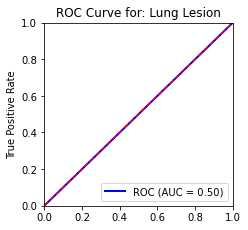

In [93]:
def plot_roc_curve(title, fpr, tpr):
    font = {'size' : 10}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(21,6))
    for i in range(len(title)):
        if(i != 12):
            auc_curve = sklearn.metrics.auc(fpr[i], tpr[i])
        else:
            auc_curve = np.nan
        plt.title(title[i])
        plt.subplot(2, 7, i+1)
        plt.plot(fpr[i], tpr[i], color='b', lw=2, label='ROC (AUC = %0.2f)' % auc_curve)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1.0])
        if i >= 7:
            plt.xlabel('False Positive Rate')
        if i % 7 == 0:
            plt.ylabel('True Positive Rate')
        else:
            plt.yticks([])

        plt.title("ROC Curve for: "+title[i])
        plt.legend(loc="lower right")

    plt.tight_layout()

    fig_size = plt.rcParams["figure.figsize"]

    fig_size[0] = 30

    fig_size[1] = 10

    plt.rcParams["figure.figsize"] = fig_size


    plt.show()

title = ["Lung Lesion"]
plot_roc_curve(title, fpr, tpr)